In [7]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip
!rm data.zip

--2020-04-19 08:23:52--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.163.29, 13.35.163.98, 13.35.163.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.163.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.03s   

2020-04-19 08:23:52 (96.0 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [0]:
import unicodedata 
import re 
import random 
import string 

import torch.nn as nn 
import torch 
import torch.optim as optim 
import torch.nn.functional as F 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
SOS_token = 0 
EOS_token = 1 

# create 3 dictionary and number words for each language
class Language:
  def __init__(self, name):
    self.name = name
    self.word2int = {}
    self.word2count = {}
    self.int2word = {0: 'SOS', 1: 'EOS'}
    self.n_words = 2
  
  def addSentence(self, sentence):
    for word in sentence.split():
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2int:
      self.word2int[word] = self.n_words
      self.word2count[word] = 1 
      self.int2word[self.n_words] = word
      self.n_words += 1 
    else:
      self.word2count[word] += 1

In [0]:
def UnicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )

def normalizeData(s):
  s = UnicodeToAscii(s.lower().strip())
  s = re.sub(r'([.!?])', r' \1', s)
  s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
  return s 

In [0]:
def readLanguage(lang1, lang2, reverse=False):
  print('Reading lines...')
  lines = open('./data/eng-fra.txt', encoding='utf8').\
        read().strip().split('\n')
  
  pairs = [[normalizeData(s) for s in l.split('\t')] for l in lines]
  
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Language(lang2)
    output_lang = Language(lang1)
  else:
    input_lang = Language(lang1)
    output_lang = Language(lang2)
  
  return input_lang, output_lang, pairs 

In [0]:
MAX_LENGTH = 10 
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
  return len(p[0].split()) < MAX_LENGTH and\
          len(p[1].split()) < MAX_LENGTH and\
          p[1].startswith(eng_prefixes)

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2):
  input_lang, output_lang, pairs = readLanguage(lang1, lang2, reverse=True)
  print("Read %d sentence pairs." %len(pairs))
  pairs = filterPairs(pairs)
  print("Trimmed %d sentence pairs." %len(pairs))

  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Length %s language vocab : %d." %(lang1, input_lang.n_words))
  print("Length %s language vocab : %d." %(lang2, output_lang.n_words))

  return input_lang, output_lang, pairs 

lang1 = "fra"
lang2 = "eng"
input_lang, output_lang, pairs = prepareData(lang1, lang2)

Reading lines...
Read 135842 sentence pairs.
Trimmed 10599 sentence pairs.
Length fra language vocab : 4345.
Length eng language vocab : 2803.


In [0]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_dim, n_layers=1, p_prob=0.1,
               bidirectional=True):
    super().__init__()
    if bidirectional:
      self.direction = 2 
    else:
      self.direction = 1 
    self.hidden_dim = hidden_dim 
    self.n_layers = n_layers 
    self.dropout = nn.Dropout(p_prob)
    self.embedding = nn.Embedding(input_size, hidden_dim)
    self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, 
                        bidirectional=True, batch_first=False)
  
  def forward(self, input, hidden):
    embedded = self.embedding(input)
    embedded = self.dropout(embedded)
    output, hidden = self.lstm(embedded, hidden)
    return output, hidden 
  
  def init_hidden(self, batch_size):
    self.batch_size = batch_size
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers*self.direction, self.batch_size, 
                         self.hidden_dim).zero_().to(device),
              weight.new(self.n_layers*self.direction, self.batch_size, 
                         self.hidden_dim).zero_().to(device))
    return hidden

In [0]:
class AttentionDecoder(nn.Module):
  def __init__(self, output_size, hidden_dim, n_layers, p_prob=0.1,
               bidirectional=True):
    super().__init__()
    if bidirectional:
      self.direction = 2 
    else:
      self.direction = 1 
    self.hidden_dim = hidden_dim 
    self.n_layers = n_layers
    self.embedding = nn.Embedding(output_size, hidden_dim)
    self.dropout = nn.Dropout(p_prob)
    self.score_learner = nn.Linear(self.direction*hidden_dim, 
                                   self.direction*hidden_dim)
    self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, 
                        bidirectional=True, batch_first=False)
    self.attn_combine = nn.Linear((self.direction*hidden_dim )+
                                  (self.direction*hidden_dim ), hidden_dim)
    self.tanh = nn.Tanh()
    self.output = nn.Linear(hidden_dim, output_size)
    self.soft = nn.Softmax(dim=1)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden, encoder_outputs):
    batch_size = input.shape[1]
    embedded = self.embedding(input)
    embedded = self.dropout(embedded)
    output, hidden = self.lstm(embedded, hidden)
    tophidden = hidden[0].view(self.n_layers, self.direction, 
                               batch_size, self.hidden_dim)[self.n_layers-1]
    # change to (batch_size, 1, direction * hidden_dim)
    tophidden = tophidden.permute(1, 2, 0).contiguous().view(batch_size, 
                                              -1, 1)
    prep_scores = self.score_learner(encoder_outputs.permute(1, 0, 2))
    scores = torch.bmm(prep_scores, tophidden)
    attn_scores = self.soft(scores)
    con_mat = torch.bmm(encoder_outputs.permute(1, 2, 0), attn_scores)
    h_tilde = self.tanh(self.attn_combine(torch.cat((con_mat, tophidden), 
                                                  dim=1).view(batch_size, -1)))
    output = self.output(h_tilde)
    output = self.log_softmax(output)
    return output, hidden, attn_scores

In [0]:
# Preparing training data
def indexesFromSentence(lang, sentence):
  return [lang.word2int[w] for w in sentence.split()]

def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device)

def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return input_tensor, target_tensor 

In [0]:
# https://towardsdatascience.com/neural-machine-translation-15ecf6b0b
from random import shuffle 

def getBatches(arr, batch_size, shuffle_data=True):
  if shuffle_data:
    shuffle(arr)
  n_batches = len(arr)//batch_size 
  batches = list(range(n_batches))
  longest_elements = list(range(n_batches))
  for idx_batch in range(n_batches):
    longest_input = 0
    longest_target = 0 
    input_tensor = list(range(batch_size))
    target_tensor = list(range(batch_size)) 
    for idx, pair in enumerate(range(batch_size*idx_batch, 
                                     batch_size*(idx_batch+1))):
      input_tensor[idx], target_tensor[idx] = tensorsFromPair(arr[pair])
      if len(input_tensor[idx]) > longest_input:
        longest_input = len(input_tensor[idx])
      if len(target_tensor[idx]) > longest_target:
        longest_target = len(target_tensor[idx])

    batches[idx_batch] = (input_tensor, target_tensor)
    longest_elements[idx_batch] = (longest_input, longest_target)
  
  # batches : list of tuple of (tensor (batch_size, input_length_i), 
  #              tensor (batch_size, target_length_i)
  return batches, longest_elements

def paddingBatch(batch):
  input_tensor = torch.nn.utils.rnn.pad_sequence(batch[0], padding_value=EOS_token)
  target_tensor = torch.nn.utils.rnn.pad_sequence(batch[1], padding_value=EOS_token)
  return input_tensor, target_tensor

In [0]:
teacher_forcing_ratio = 0.5

def trainBatch(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, clip=5):
  batch_size = input_tensor.shape[1]
  encoder_hidden = encoder.init_hidden(batch_size)
  
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  output_length = target_tensor.size(0)
  loss = 0 

  encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

  decoder_input = torch.zeros(1, batch_size, device=device).type(torch.long)
  decoder_input.fill_(SOS_token)
  decoder_hidden = encoder_hidden 

  use_teacher_forcing = True if random.random() > teacher_forcing_ratio else False
  
  if use_teacher_forcing:

    for i in range(output_length):
        decoder_output, decoder_hidden, _ = decoder(decoder_input, 
                                               decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[i])
        decoder_input = target_tensor[i].view(1, -1)

  else:
    for i in range(output_length):
      decoder_output, decoder_hidden, _ = decoder(decoder_input, 
                                              decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[i])

      top_n, top_i = decoder_output.topk(1, dim=1)
      decoder_input = top_i.squeeze(1).detach().view(1, -1)
  
  loss.backward()

  torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
  torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

  encoder_optimizer.step()
  decoder_optimizer.step()
  return loss.item() / output_length

In [0]:
def train(train_batches, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_criterion):

	round_loss = 0
	i = 1
	for batch in train_batches:
		i += 1
		(input_batch, target_batch) = paddingBatch(batch)
		batch_loss = trainBatch(input_batch, target_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_criterion)
		round_loss += batch_loss

	return round_loss / len(train_batches)

In [0]:
import matplotlib.pyplot as plt
import time 

def timeSince(since):
  now = time.time()
  s = now - since 
  m = s // 60 
  s -= m*60 
  return " %dm %ds " %(m, s)

In [0]:
def trainIters(encoder, decoder, lr_schedule, n_epochs, learning_rate=1):

  start = time.time()
  plot_losses = []
  print_loss_total = 0 
  plot_loss_total = 0 
  batch_size = 32

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

  criterion = nn.NLLLoss()
  # training_pairs = [tensorsFromPair(random.choice(pairs)) 
  #                   for i in range(n_iters)]

  for e in range(n_epochs):

    if e in lr_schedule.keys():
      learning_rate /= lr_schedule.get(e)

    batches, _ = getBatches(pairs, batch_size)
    train_loss = train(batches, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
      
    print("Iter: %s \nLearning Rate: %s \nTime: %s \nTrain Loss: %s \n" 
          % (e, learning_rate, timeSince(start), train_loss))
    
    evaluateRandomly(encoder, decoder, 2)
    
    # save losses 
    plot_losses.append(train_loss)
      
  return plot_losses
    

In [0]:
def evaluate(encoder, decoder, sentence, batch_size=1, max_length=MAX_LENGTH):
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_tensor = input_tensor.view(-1, 1)
    encoder_hidden = encoder.init_hidden(1)
    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
  
    decoder_attentions = torch.zeros(max_length, max_length)
    decoder_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)
    decoder_hidden = encoder_hidden 
    results = []


    for i in range(max_length):
      decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
      # print(attn_weights.data)
      attn_weights.squeeze_()
      decoder_attentions[i][:attn_weights.size(0)] = attn_weights.data
      top_n, top_i = decoder_output.topk(1)
      pred_id = top_i.item()
      if pred_id == EOS_token:
        results.append('<EOS>')
        break
      results.append(output_lang.int2word[pred_id])
      decoder_input = torch.tensor([[pred_id]], dtype=torch.long, device=device)
    return results, decoder_attentions

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    results, _ = evaluate(encoder, decoder, pair[0])
    print('< ', ' '.join(results)) 
    print('')

In [86]:
# input vocab word size
input_size = input_lang.n_words

# hidden dimention of the Encoder and Decoder 
hidden_dim = 440

# number layer of lstm 
n_layers = 2

# output vocab word size 
output_size = output_lang.n_words

lr_schedule = {}

p_prob = 0.2 

encoder = Encoder(input_size, hidden_dim, n_layers, p_prob).to(device)
decoder = AttentionDecoder(output_size, hidden_dim, n_layers, p_prob).to(device)

n_epochs = 35
plot_losses = trainIters(encoder, decoder, lr_schedule, n_epochs)

Iter: 0 
Learning Rate: 1 
Time:  0m 15s  
Train Loss: 5.7243578701461075 

> il se plaint toujours de quelque chose .
= he s always complaining about something .
<  he s a of . <EOS>

> il a des chances de remporter le jeu .
= he is likely to win the game .
<  he s a of . <EOS>

Iter: 1 
Learning Rate: 1 
Time:  0m 32s  
Train Loss: 2.867832136074144 

> il se fait vieux .
= he s getting old .
<  he is very . . <EOS>

> vous n etes pas contusionnee .
= you re not bruised .
<  you re not my . <EOS>

Iter: 2 
Learning Rate: 1 
Time:  0m 47s  
Train Loss: 2.1438630243962784 

> je ne me sens pas offense .
= i m not offended .
<  i m not to . . . . <EOS>

> j essaie de me rappeler .
= i m trying to remember .
<  i m going to . . . <EOS>

Iter: 3 
Learning Rate: 1 
Time:  1m 3s  
Train Loss: 1.8109776303847387 

> tu es un beau papillon .
= you are a beautiful butterfly .
<  you re a good person . <EOS>

> vous n etes pas normales .
= you re not normal .
<  you re not the . . . <EOS>

Iter

Text(0, 0.5, 'Training loss')

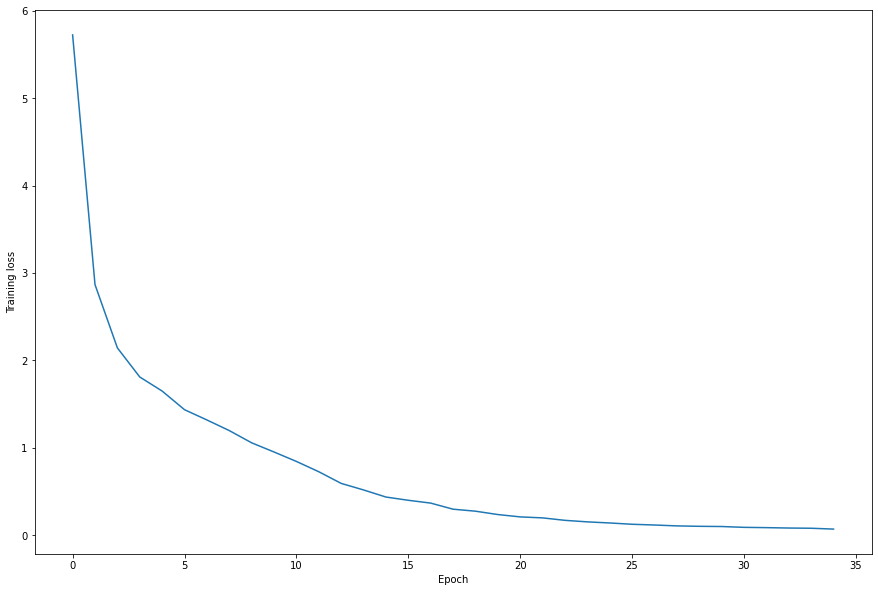

In [99]:
plt.figure(figsize=(15, 10))
plt.plot(plot_losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")

In [0]:
def showAttention(attentions, input, output):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.cpu().numpy(), cmap="gray")
  fig.colorbar(cax)

  ax.set_xticklabels(['']+input.split(' ')+['<EOS>'], rotation=90)
  ax.set_yticklabels(['']+output)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def evaluateAndShowAttention(n=3):
  for i in range(n):
    pair = random.choice(pairs)
    print(pair[0])
    output, attentions = evaluate(encoder, decoder, pair[0])
    showAttention(attentions, pair[0], output)

je suis enchantee d etre ici .


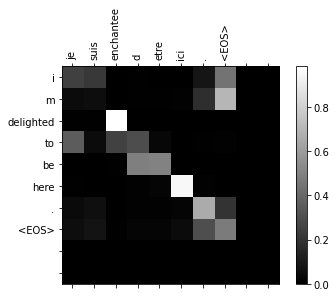

il est tres erudit .


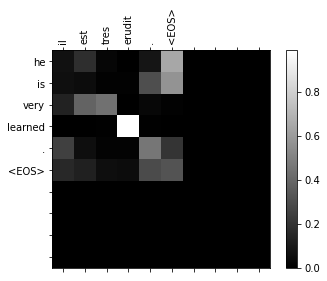

tu as tort .


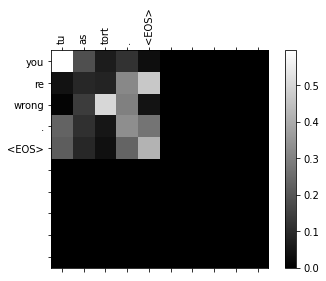

In [90]:
import matplotlib.ticker as ticker 

evaluateAndShowAttention()


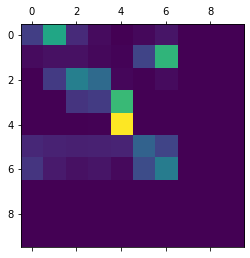

In [91]:
output, attentions = evaluate(encoder, decoder, "vous etes un petit menteur .")
plt.matshow(attentions.numpy())